# Goal
The key goal of the tutorial is to teach users how to load, manipulate, and render 3D meshes using different settings and configurations.

## Revision of Terms

### Vertex
A vertex (plural: vertices) is not a line but a point in 3D space. In the context of 3D graphics, a vertex is a single point described by coordinates (usually X, Y, and Z) that determines its position in space. When multiple vertices are connected by lines, they form edges, and a closed set of edges forms a polygon (typically a triangle in 3D graphics).

### Edge
An edge in 3D graphics is a straight line segment connecting two vertices. It serves as one of the basic elements of a mesh, where multiple edges define the shape of a 3D object.

### UV Coordinates
UV coordinates are used to map a 2D texture onto a 3D model. They are analogous to XY coordinates on a flat surface but are used specifically for texturing models. Each vertex of a 3D model can be assigned UV coordinates that correspond to a position on a texture image. When the texture is applied, it uses these coordinates to determine how the image should wrap around the model. "U" and "V" represent the axes in the texture space, where U is the horizontal axis and V is the vertical axis.

### Vertex Normals
A vertex normal is a vector that points perpendicular from the surface of the mesh at the location of the vertex. Normals are used in lighting calculations to determine how light bounces off a surface at that vertex, affecting how shiny or flat the surface appears. They are crucial for achieving realistic lighting and shading effects in 3D rendering.

## New Terms
1. **Mesh**: In computer graphics, a mesh is a collection of **vertices**, **edges**, and **faces** that defines the shape of a 3D object. Vertices are points in 3D space, edges connect these points, and faces are the surfaces bounded by edges. A mesh essentially forms the geometric structure of any 3D model.

2. **Texture**: A texture is an image applied to the surface of a mesh to give it color, detail, or visual depth. When a texture is mapped to a mesh, it covers the mesh's surface like wrapping paper, adding realism by depicting materials, patterns, or other characteristics. The process involves linking points on the mesh (vertices) to specific points on the texture image, defined through UV coordinates.

3. **UV Coordinates**: These are coordinates used to map the 2D texture onto the 3D mesh. Each vertex in a mesh is assigned UV coordinates that correspond to a point on the texture image. "U" and "V" represent the axis in the texture space, similar to "x" and "y" in a 2D space.

4. **Rendering**: This is the process of generating an image from a model. In the context of 3D graphics, rendering is the final process that transforms a model into an image by simulating light, shadow, color, and texture. The renderer calculates how light interacts with the objects, determines the color of pixels, and produces a 2D image.

5. **Renderer Components**:

 - Camera: Defines the perspective from which the scene is viewed. It mimics the position and behavior of a real-world camera, including aspects like angle and depth of field.

 - Light: Simulates real-world lighting. Different types of lights (like point lights, directional lights) can mimic various natural and artificial light sources.

 - Shader: A program that tells the renderer how to draw each pixel. It determines how the lighting interacts with the surfaces of the mesh, influencing aspects like brightness, color, and texture visibility.

 - Rasterization: Converts the vector graphics (like the vertices of a mesh) into a raster image (pixels), which involves determining which pixels correspond to which triangle of the mesh.

6. **PyTorch3D's Renderer**: In the context of the tutorial, PyTorch3D uses a modular approach to build a renderer that includes:

 - MeshRasterizer: Responsible for transforming the 3D coordinates of the mesh into 2D pixel coordinates in the image. It decides which parts of the mesh are visible based on the camera perspective.

 - SoftPhongShader: A type of shader that applies both shading (to give depth and contour using lighting) and texturing (applying the texture image details to the surface). The "Phong" part refers to the Phong reflection model, a technique used for simulating the way light interacts with surfaces.

By setting up a renderer with these components, you can render a mesh with textures under varying lighting and from different camera viewpoints. Each rendered image will reflect changes in these parameters, showing how the object would look under different conditions. This fundamental understanding helps in exploring more complex 3D rendering tasks, especially when dealing with real-world simulations or creating detailed visualizations in computer graphics and augmented reality applications.

# Installation

**WARNING** : Pytorch3D installation takes around 30 minutes

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-jjgxsk4z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-jjgxsk4z
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60242668 sha256=32814242e00a76bd0e8f6069e4ae9ca99ee7fbf796b734d58927a69f20d34435
  Stored in directory: /tmp/pip-ephem-wheel-cache-83l8iijl/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=6d154e40f029570a1c8bdd7

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2025-04-10 13:22:48--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-04-10 13:22:48 (32.6 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



# Mesh and texture loading

In [ ]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2025-04-10 13:22:48--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.05s   

2025-04-10 13:22:49 (6.23 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2025-04-10 13:22:49--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%

**OBJ File**: The OBJ file format is a simple data format that represents 3D geometry alone — namely, the position of each vertex, the UV position of each texture coordinate vertex, the vertex normals, and the faces that make each polygon defined as a list of vertices, and texture vertices. Vertices are stored in a counter-clockwise order by default, making explicit declaration of face normals unnecessary. OBJ coordinates have no units, but OBJ files can contain scale information in a human readable comment line.

**MTL File:** An MTL file accompanies the OBJ file and describes the materials used for the objects in the OBJ file. It defines the material name followed by properties such as ambient, diffuse, and specular reflection coefficients (which control how the material reflects light), and texture filenames. Each material described in an MTL file can be applied to any part of the OBJ model, allowing complex objects to have a rich variety of surface appearances.

**Example of .obj file content:**

```
mtllib Bush1.mtl // This line links the OBJ file to its corresponding MTL file, which contains material definitions (like color and specular values) — in your case, Bush1.mtl. This tells the software: "Use materials defined over there."

o bush_leaves // This defines the name of the object. The o keyword is used to group subsequent vertices and faces under a named object. This is useful when your model has multiple parts (e.g., o stem, o leaves, etc.).

v -0.029051 0.016169 0.012267 // Lines that start with v define vertices — the fundamental points in 3D space. Each vertex has an X, Y, and Z coordinate:

v 0.013785 -0.000000 0.032647

v 0.029051 -0.016169 -0.012267

v -0.013785 0.000000 -0.032647

v -0.019368 0.841275 -0.011910

v 0.009190 0.830495 0.001677

v 0.019368 0.819716 -0.028266

v -0.009190 0.830495 -0.041853

v 0.139827 0.965990 -0.074151

v 0.158807 0.948963 -0.059850

v 0.162273 0.932656 -0.083865

...

f 4178 4182 4181 4177 // Lines starting with f define faces (usually polygons — often triangles or quads). Each number references a previously defined vertex, by its line number in the file (1-based index).  "Create a face (surface) by connecting the vertices 4178, 4182, 4181, and 4177 in order." This forms a polygon — a quad (4-sided).

f 4179 4183 4182 4178

f 4180 4184 4183 4179

f 4181 4185 4188 4184

f 4182 4186 4185 4181

f 4183 4187 4186 4182

f 4184 4188 4187 4183

f 4185 4189 4192 4188

f 4186 4190 4189 4185

f 4187 4191 4190 4186

f 4188 4192 4191 4187

f 4189 4193 4196 4192

f 4190 4194 4193 4189

f 4191 4195 4194 4190

f 4192 4196 4195 4191

f 4193 4197 4200 4196

f 4194 4198 4197 4193

f 4195 4199 4198 4194

f 4196 4200 4199 4195

...
```



**Example of a .mtl file**


```
# Blender MTL File: 'Bush1.blend'
# Material Count: 2

newmtl Material.001
Ns 94.117647 // Shininess — how glossy the surface looks.
Ka 0.000000 0.000000 0.000000 // Diffuse color — the base color of the material. This is what gives the object its apparent color under light.
Ka: Ambient color
Kd 0.275884 0.343381 0.000000
Ks 0.189320 0.189320 0.189320 // Specular color — how shiny the material appears.
Ni 1.000000
d 1.000000
illum 2

newmtl Material.002
Ns 29.411765
Ka 0.000000 0.000000 0.000000
Kd 0.201901 0.116948 0.078615
Ks 0.166667 0.166667 0.166667
Ni 1.000000
d 1.000000
illum 2
```




In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
mesh_path = "cow_mesh/cow.obj"
# mesh_path = "bush_mesh/Bush1.obj"

obj_filename = os.path.join(DATA_DIR, mesh_path)

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

## Visualization of the Texture Map

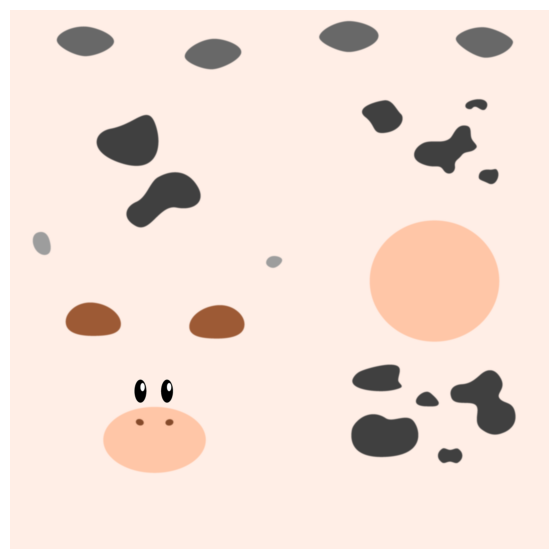

In [ ]:
if mesh.textures is not None:
    plt.figure(figsize=(7,7))
    texture_image = mesh.textures.maps_padded()
    plt.imshow(texture_image.squeeze().cpu().numpy())
    plt.axis("off")
    plt.show()
else:
    print("No texture image found in mesh — skipping texture visualization.")

Here, mesh.textures.maps_padded() retrieves the texture map from the mesh. The method maps_padded() is used to get the texture images associated with the mesh, where padding ensures that all images are the same size, which is necessary for batch processing or uniform handling.

texture_image.squeeze() removes any single-dimensional entries from the dimensions of the texture image array, simplifying the array structure for easier handling.

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

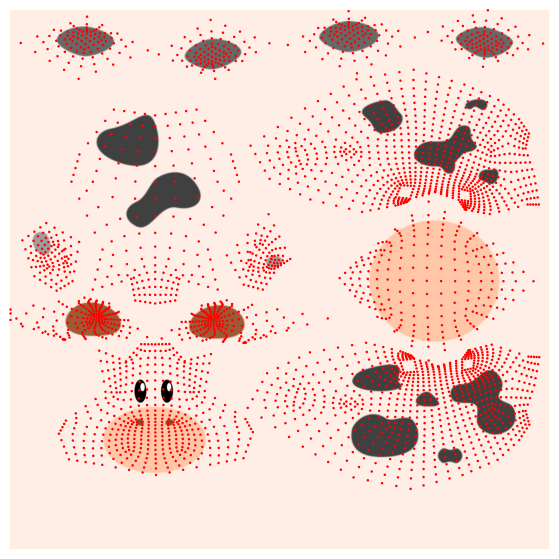

In [ ]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off");

# Create a renderer
A renderer in PyTorch3D is composed of a rasterizer and a shader which each have a number of subcomponents such as a camera (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a renderer which uses a perspective camera, a point light and applies Phong shading. Then we learn how to vary different components using the modular API.

In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(2.7, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

The term "azimuth" in 3D graphics and in many scientific fields refers to the angle between a reference direction (usually North) and a point, measured in the horizontal plane. In the context of camera positioning in computer graphics:

Azimuth angle is used to specify the direction the camera is pointing around the vertical axis (up-down axis in most 3D environments), which typically represents rotation around the Y-axis. An azimuth of 0 degrees usually means facing directly towards the positive Z-axis, and an azimuth of 180 degrees would mean facing directly towards the negative Z-axis.

`look_at_view_transform:` This function generates the rotation (R) and translation (T) matrices needed to position the camera in the 3D space. Here, the camera is positioned 2.7 units away from the origin, with 0 degrees of elevation and 180 degrees azimuth. This means the camera is rotated to face the front of the object, as the object is oriented to face the -Z direction in this coordinate system.

`FoVPerspectiveCameras`: This class creates a perspective camera, which mimics how the human eye perceives the world, making distant objects appear smaller than those close by. The rotation and translation matrices from look_at_view_transform are used to set the camera’s position and orientation.

In [ ]:
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1
)

Rasterization Settings: These settings define how the 3D model is converted into a 2D image.

- `image_size: `The resolution of the output image (512x512 pixels).

- `blur_radius:` Sets the radius for edge softening (here it is 0, meaning no blur).

- `faces_per_pixel: `Determines the number of faces (polygons) that can affect the color of a pixel. Setting this to 1 means only the closest face to the camera at each pixel influences the color, ensuring sharp images.

In [ ]:
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

Point Lights: This simulates a light source that emits light in all directions from a single point. Here, a point light is placed three units along the -Z axis, in front of the object, ensuring it is well-lit from the front.

In [ ]:
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)

MeshRenderer: This is the main component that takes a mesh and turns it into an image based on the settings provided.

- MeshRasterizer: This component takes the geometric data of the mesh and converts it into a raster image format (a grid of pixels). It uses the camera settings for perspective and the rasterization settings to determine how vertices map to pixels.

- SoftPhongShader: This shader uses the Phong reflection model, which is a method for simulating the way light interacts with surfaces. It considers the texture of the mesh (if any), the lighting setup, and the camera perspective to calculate how light reflects at different points on the mesh’s surface. The "Soft" part refers to how the shader handles the edges and shading to give a smoother appearance to the lit areas of the mesh.

# Render the mesh

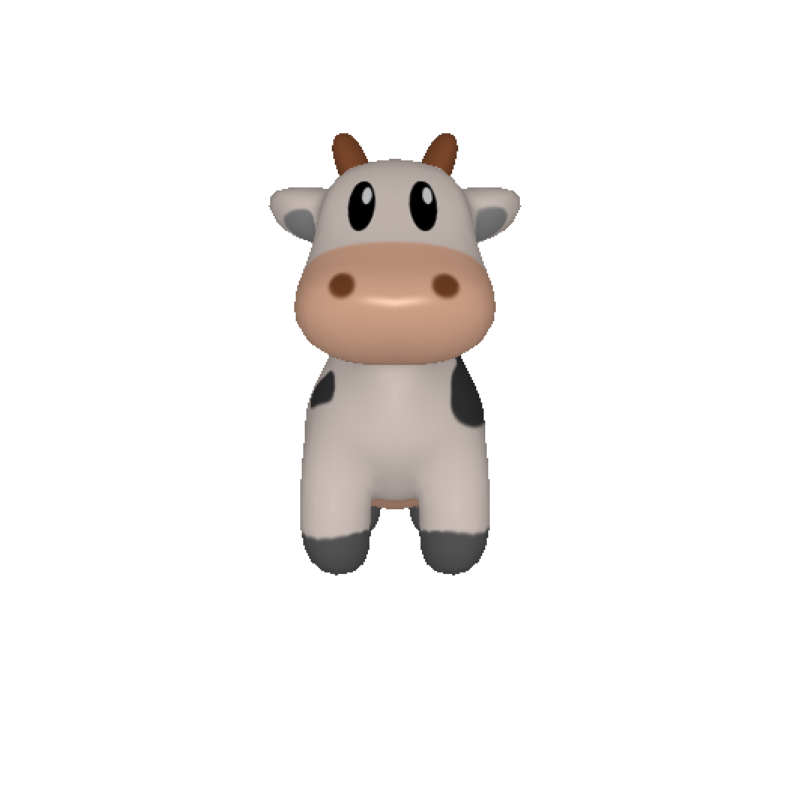

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

Breaking Down 0, ..., :3

- 0: This specifies the index of the first dimension. In this context, it refers to the first image in the batch of images. If renderer(mesh) produces a batch of images (even if it's a batch of one), this index selects the first image from that batch.

- ... (Ellipsis): This is used as a placeholder for the remaining dimensions that are not explicitly mentioned. It means "include all indices along this dimension." It's particularly useful in higher-dimensional arrays to keep the code cleaner and more readable without needing to specify every single dimension explicitly.

- :3: This slices the last dimension from its start up to but not including index 3. Since image data typically contains color channels in the last dimension (e.g., RGB where indices 0, 1, and 2 correspond to Red, Green, and Blue channels respectively), :3 ensures that only these three primary color channels are included. If the tensor has an alpha channel or any other extra channels, they will not be included.

# Move the light behind the object and re-render

We can pass arbitrary keyword arguments to the rasterizer/shader via the call to the renderer so the renderer does not need to be reinitialized if any of the settings change/

In this case, we can simply update the location of the lights and pass them into the call to the renderer.

The image is now dark as there is only ambient lighting, and there are no specular highlights.

In [ ]:
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

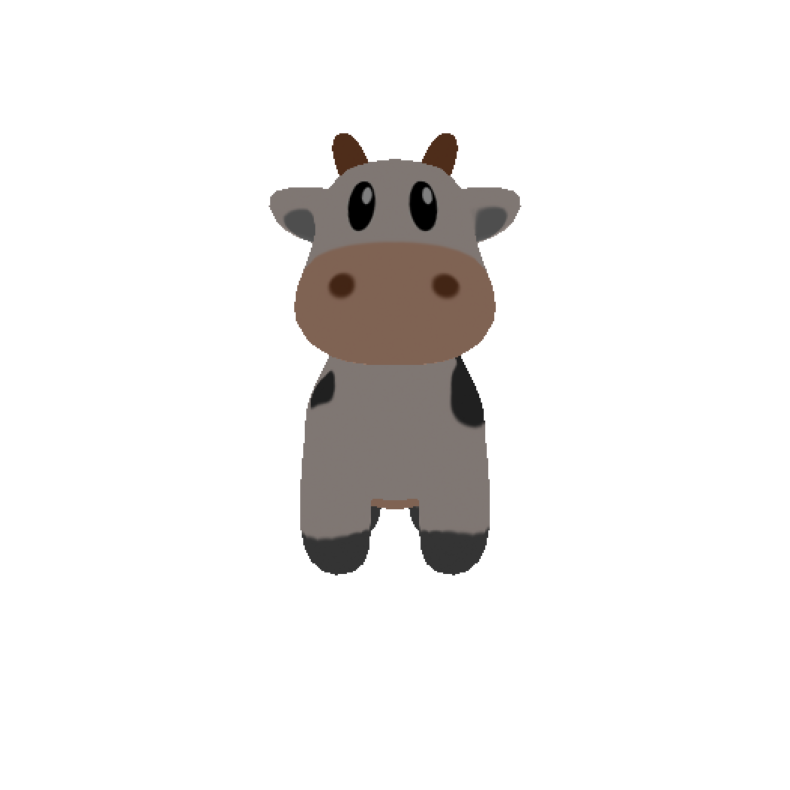

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

# Rotate the object, modify the material properties or light properties

We can also change many other settings in the rendering pipeline. Here we:

- change the viewing angle of the camera
- change the position of the point light
- change the material reflectance properties of the mesh

In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

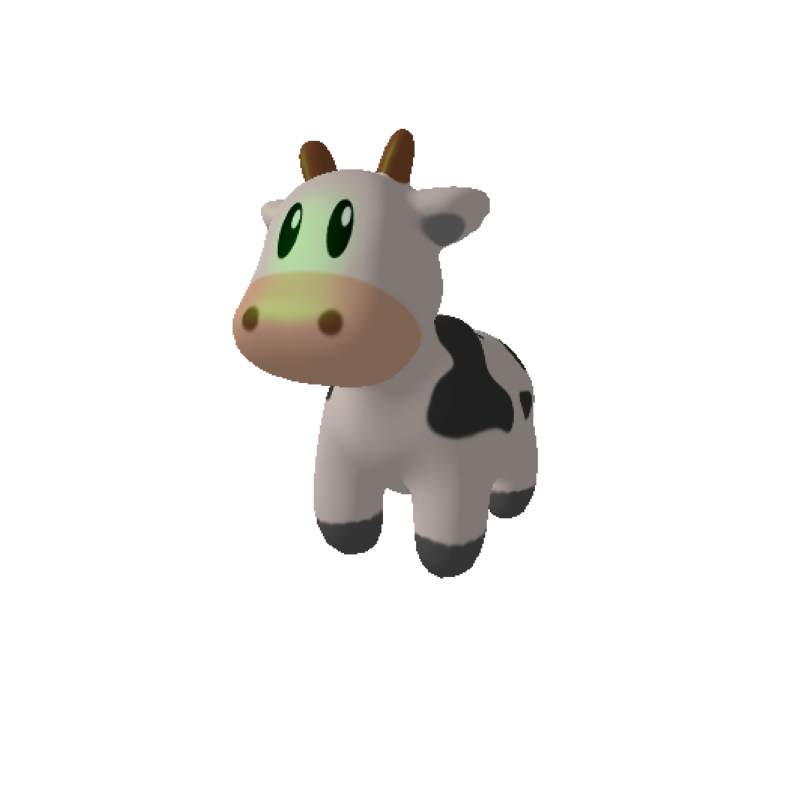

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");